In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Start with the 1-D diffusion equation:

$$
\frac{\partial\phi}{\partial t} = D\frac{\partial^2\phi}{\partial x^2}
$$

where $\phi$ is the density of the fluid.


Using a finite-differences method, we can define

$$
\frac{\partial^2\phi}{\partial x^2} = \frac{\phi(x + h) - 2\phi(x) + \phi(x - h)}{h^2}
$$

where h is some arbritrarily small step size

In [2]:
def dx_sq(phi):
    '''Calculates d^2(phi)/dx^2'''
    phi_plus_h = phi[0:-2]
    phi_minus_h = phi[2:]
    phi_centered = phi[1:-1]
    return phi_plus_h - 2 * phi_centered + phi_minus_h

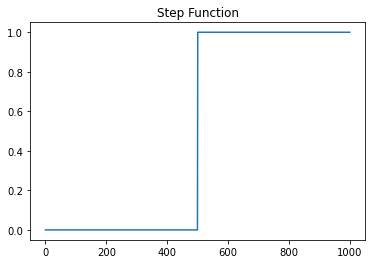

In [3]:
phi = np.asarray(np.append(np.zeros(500), np.ones(500)))
plt.plot(phi)
plt.title('Step Function')
plt.show()

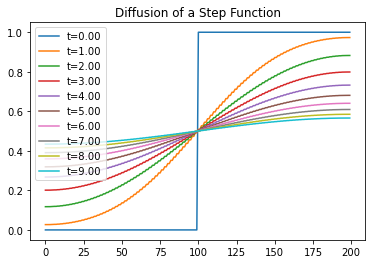

In [4]:
D = 1000
T = 10

dt = (1/2) / D
n = round(T/dt)
n

phi = np.asarray(np.append(np.zeros(100), np.ones(100)))

for i in range(n):
    if i % (n/10) == 0:
        plt.plot(phi, label=f't={i*dt:.2f}')
    
    phi_dx2 = dx_sq(phi)
    phi_centered = phi[1:-1]
    phi[1:-1] = phi_centered + (dt * D * phi_dx2)
    
    # Apply Neumann B.C.
    phi[0] = phi[1]
    phi[-1] = phi[-2]

plt.title('Diffusion of a Step Function')
plt.legend()
plt.show()

# Calibrating Diffusion Coefficient to Data
- Starting from initial conditions (first frame), simulate the diffusion for a given diffusion coefficient called $D_{model}$
- Edge intensities are unreliable so use the intensities near the center (this is because while we assume reflecting B.C, the real data has bleaching and is the boundaries are slightly absorbing). For this purpose, we will we use the slope of the intensity curve near the center as a metric called $m$.
- Match frames to simulated timepoints in simulation using $m$
- Do a linear fit to get the sim time to frame number conversion factor
- Convert $D_{model}$ to a real diffusion coefficient $D_{NS}$ by converting from pix/sim time to um/real time

In [5]:
def calc_m(phi, w=30):
    '''Calculates the slope around center of intensity curve''' 
    center = int(len(phi) / 2)
    return (phi[center + w] - phi[center - w]) / (2 * w)

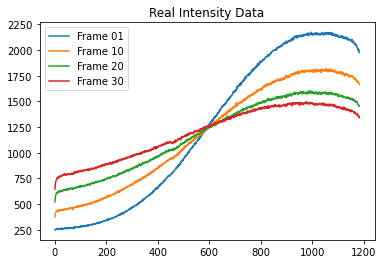

In [6]:
for frame in ['01', '10', '20', '30']:
    intensities = pd.read_csv(f'intensity_data/frame_{frame}.csv')['Value']
    plt.plot(intensities, label=f'Frame {frame}')
plt.title('Real Intensity Data')
plt.legend()
plt.show()

In [7]:
frames_checked = [str(n).zfill(2) for n in range(2, 58)]

In [8]:
intensities_real = [pd.read_csv(f'intensity_data/frame_{frame}.csv')['Value'] for frame in frames_checked]
m_real = [calc_m(intensity) for intensity in intensities_real]

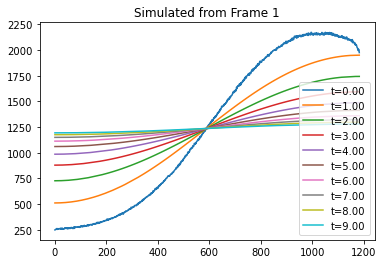

In [9]:
D = 50000
T = 10
dt = (1/2) / D
n = round(T/dt)

phi = np.asarray(pd.read_csv('intensity_data/frame_01.csv')['Value'])
matches = {m: [] for m in m_real}

m_tol = 0.01
for i in range(n):
    if i % (n/10) == 0:
        plt.plot(phi, label=f't={i*dt:.2f}')
    
    phi_dx2 = dx_sq(phi)
    phi_centered = phi[1:-1]
    phi[1:-1] = phi_centered + (dt * D * phi_dx2)
    m_n = calc_m(phi)
    for m in m_real:
        if (m_n > m - m_tol and m_n < m + m_tol):
            matches[m].append(i * dt)
    
    # Apply Neumann B.C.
    phi[0] = phi[1]
    phi[-1] = phi[-2]
    
plt.title('Simulated from Frame 1')
plt.legend()
plt.show()

In [10]:
matched_times = []
matched_times_error = []

for k, v in matches.items():
    matched_times.append(np.mean(v))
    matched_times_error.append(np.std(v))

matched_times;

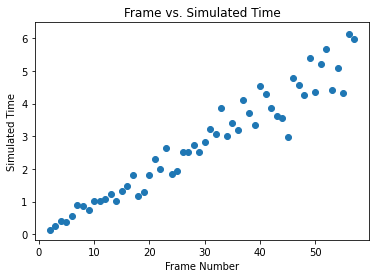

In [11]:
frame_nums = np.arange(2, 58)

plt.title('Frame vs. Simulated Time')
plt.errorbar(frame_nums, matched_times, matched_times_error, linestyle=' ', marker='o')
plt.xlabel('Frame Number')
plt.ylabel('Simulated Time')
plt.show()

In [12]:
from scipy.optimize import curve_fit

def lin_fit(x, m, b):
    return m*x+b

params, cov = curve_fit(lin_fit, frame_nums, matched_times, absolute_sigma=True)

params

array([ 0.09684703, -0.06622857])

In [13]:
np.sqrt(cov[0][0]) / params[0]

0.08536729822393857

In [14]:
np.sqrt(cov)

C:\Users\nguye\AppData\Local\Temp\ipykernel_11172\2717691675.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(cov)


array([[0.00826757,        nan],
       [       nan, 0.27810264]])

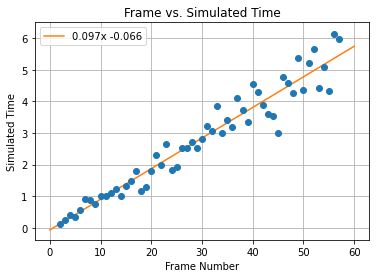

In [15]:
x_space = np.linspace(0, 60, 1000)
plt.title('Frame vs. Simulated Time')
plt.errorbar(frame_nums, matched_times, matched_times_error, linestyle=' ', marker='o')
plt.plot(x_space, lin_fit(x_space, *params), label=f"{params[0]:.3f}x {params[1]:.3f}")
plt.legend()
plt.grid()
plt.xlabel('Frame Number')
plt.ylabel('Simulated Time')
plt.show()

##### Slope of this line is the conversion factor btwn simulated time and frame number. (Simulated time / slope = frame number)

In [16]:
# 1 frame = 5m irl
# width of the channel is 1mm
# D_model is in pixels^2/sim time

In [17]:
pix_to_micron = 1000/len(intensities_real[0])
pix_to_micron
sim_time_to_real_time = 300 / params[0]

In [18]:
real_D = D * ((pix_to_micron) ** 2) / sim_time_to_real_time
real_D

11.514143635011534

## Diffusion coefficient = $11.5 \pm 0.9$ um^2/s